#**Project Title:**

#**Time Series Model Deployment**

# Installing Libraries

In [1]:
#Installing required libraries
!pip install yFinance statsmodels matplotlib pandas

# Importing libraries

In [2]:
#Importing necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


#Loading the data

In [3]:
#Getting the data
gold_data = yf.download('GC=F', start = "2005-01-01", end = "2025-07-01", interval = "1mo")
gold_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2005-01-01,421.799988,431.000000,418.700012,431.000000,115342
2005-02-01,436.500000,436.000000,410.100006,422.200012,8468
2005-03-01,428.700012,446.399994,424.700012,435.000000,3171
2005-04-01,435.000000,438.200012,422.700012,428.299988,2579
2005-06-01,435.899994,442.500000,414.000000,416.399994,6950


In [5]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210 entries, 2005-01-01 to 2025-05-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GC=F)   210 non-null    float64
 1   (High, GC=F)    210 non-null    float64
 2   (Low, GC=F)     210 non-null    float64
 3   (Open, GC=F)    210 non-null    float64
 4   (Volume, GC=F)  210 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 9.8 KB


#Handling missing values and filtering the data

In [4]:
#Keeping only closing price and remove missing values

gold= gold_data[['Close']].copy()  #Making the copy with only closing price
gold.columns=['Price']              #Renaming the column close as price
gold.dropna(inplace = True)
gold.head()

,Price
Date,
2005-01-01,421.799988
2005-02-01,436.500000
2005-03-01,428.700012
2005-04-01,435.000000
2005-06-01,435.899994


#Visualization

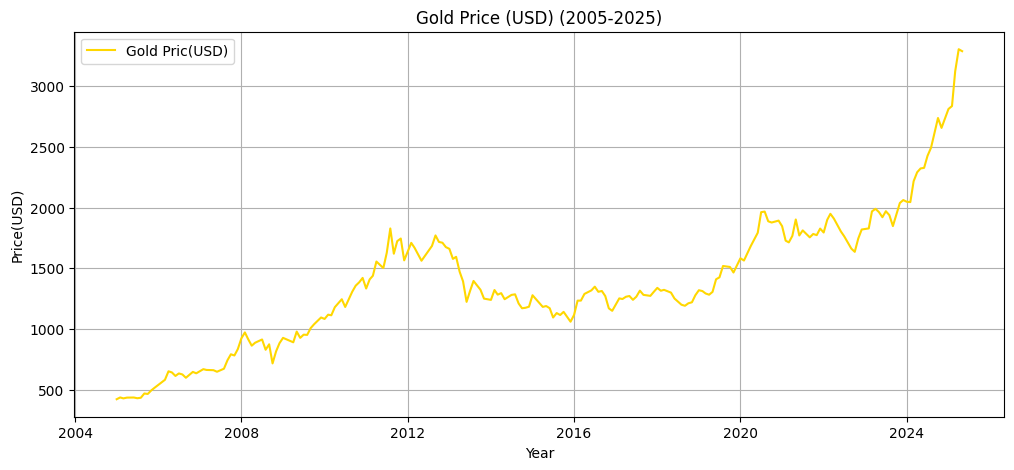

In [6]:
#Plot
plt.figure(figsize=(12,5))
plt.plot(gold, label="Gold Pric(USD)", color= 'gold')
plt.title('Gold Price (USD) (2005-2025)')
plt.xlabel('Year')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.legend()
plt.show()

#Seasonal Decomposition

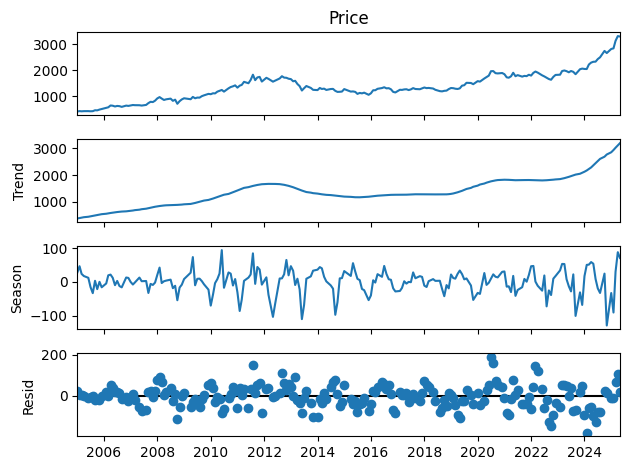

In [8]:
#STL Decomposition
stl= STL(gold['Price'],period=12)
result=stl.fit()
result.plot()
plt.show()

#Checking Stationarity using ADF test

In [9]:
#ADF Test for Stationarity
adf_result =adfuller(gold['Price'])
print('ADF Statistic: ', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] <= 0.05:
  print('\n The series is stationary')
else:
  print('\n The series is non-stationary')

ADF Statistic:  1.535441436691233
p-value: 0.997650368895262

 The series is non-stationary


**Observations:**
Since, the data that we are working with is not stationary,
we cannot use AR, MA, ARMA models  

#Making the data Stationary

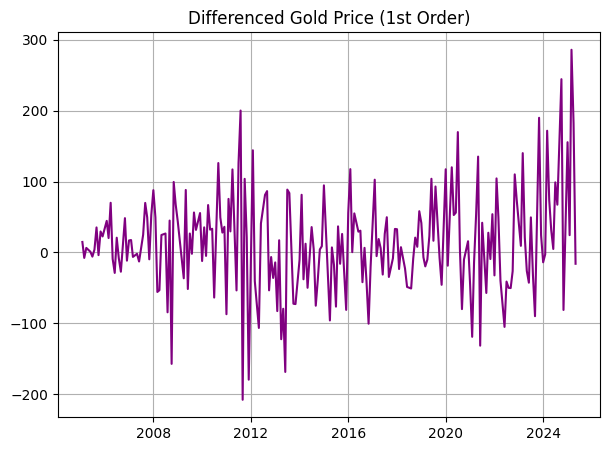

In [10]:
#Differencing to make series stationary
gold_diff =gold['Price'].diff().dropna()

plt.figure(figsize=(7,5))
plt.plot(gold_diff, label="Gold Pric(USD)", color= 'Purple')
plt.title('Differenced Gold Price (1st Order)')
plt.grid(True)
plt.show()

#ACF and PACF plots

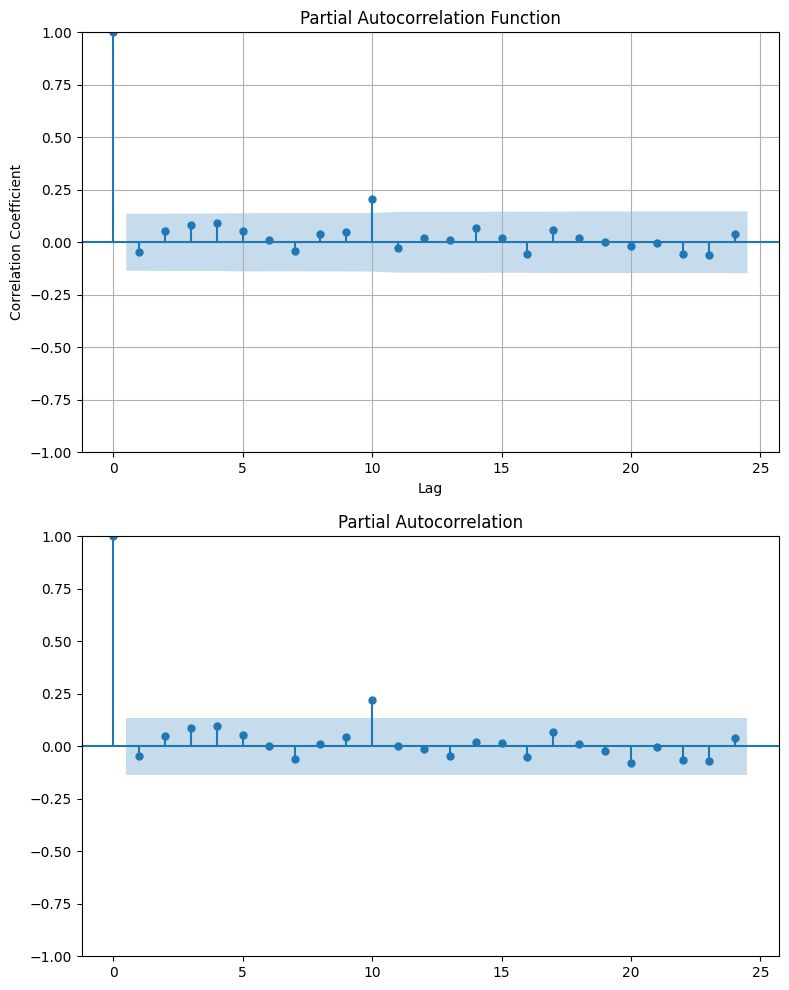

In [14]:
fig, (ax1,ax2)= plt.subplots(2,1, figsize=(9,12))

#ACF plot
plot_acf(gold_diff,ax=ax1, lags =24, alpha =0.05)
ax1.set_title('Autocorrelation Function')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel('Lag')
ax1.grid(True)


#PACF plot
plot_pacf(gold_diff,ax=ax2, lags =24, alpha =0.05)
ax1.set_title('Partial Autocorrelation Function')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel('Lag')
ax1.grid(True)

**Observations:**
* Significant spike are seen at lag 10.
* PACF cuts after lag( p = 1)
* ACF cuts after lag (q = 1)

#Model Building

#ARIMA model

In [23]:
#Fitting the ARIMA Model (Basic)
model_arima=ARIMA(gold['Price'], order=(1,1,1))
model_arima_fit = model_arima.fit()
print('\n ARIMA Model Summary: \n')
print(model_arima_fit.summary())


 ARIMA Model Summary: 

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1192.363
Date:                Sun, 20 Jul 2025   AIC                           2390.727
Time:                        09:48:43   BIC                           2400.754
Sample:                             0   HQIC                          2394.781
                                - 210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9837      0.066    -14.858      0.000      -1.114      -0.854
ma.L1          0.9654      0.085     11.296      0.000       0.798       1.133
sigma2      5279.5055    42

#Forecasting for next 12 months using ARIMA

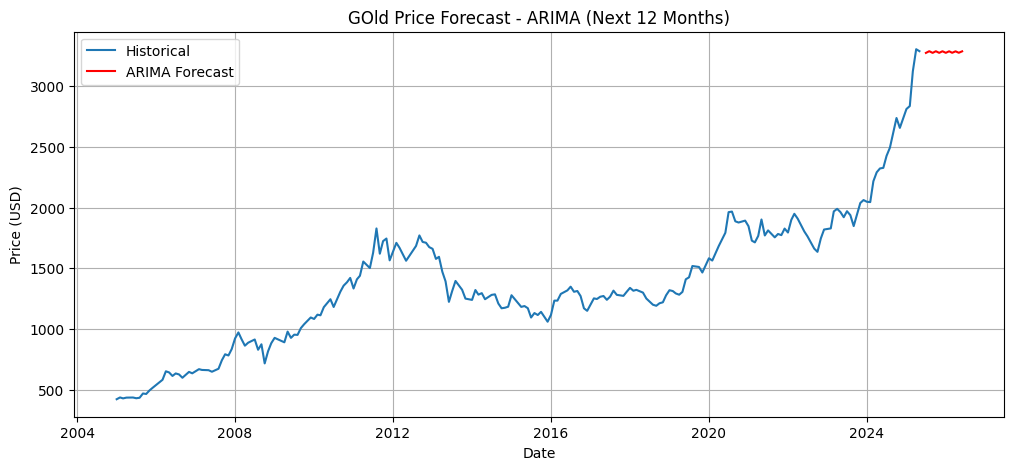

In [24]:
#Forecasting using ARIMA model
forecast_arima = model_arima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = gold.index[-1] + pd.DateOffset(months = 1),periods = 12,freq= ' M')

#Plot
plt.figure(figsize=(12,5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_arima, label ='ARIMA Forecast', color='red')
plt.title('GOld Price Forecast - ARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


#SARIMA model

In [25]:
#Fitting the SARIMA Model (Basic)
model_sarima=SARIMAX(gold['Price'], seasonal_order=(1,1,1,10))
model_sarima_fit = model_sarima.fit()
print('\n SARIMAX Model Summary: \n')
print(model_sarima_fit.summary())


 SARIMAX Model Summary: 

                                      SARIMAX Results                                       
Dep. Variable:                                Price   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 10)   Log Likelihood               -1144.261
Date:                              Sun, 20 Jul 2025   AIC                           2296.522
Time:                                      09:49:05   BIC                           2309.715
Sample:                                           0   HQIC                          2301.861
                                              - 210                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.004    269.312      0.000       0.991     

#Forecasting for next 12 months using SARIMA

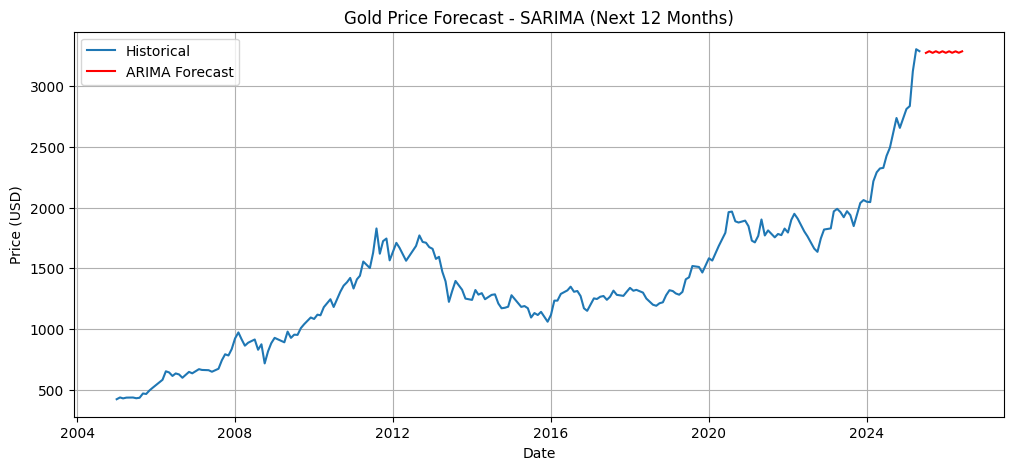

In [22]:
#Forecasting using SARIMA model
forecast_sarima = model_sarima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = gold.index[-1] + pd.DateOffset(months = 1),periods = 12,freq= ' M')

#Plot
plt.figure(figsize=(12,5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_arima, label ='ARIMA Forecast', color='red')
plt.title('Gold Price Forecast - SARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

#Model Comparision

In [26]:
#Model Comparision
print('Model Comparision :')
print(f"ARIMA Model AIC: {model_arima_fit.aic}")
print(f"SARIMA Model AIC: {model_sarima_fit.aic}")

#Select model based on lesser AIC
if model_arima_fit.aic < model_sarima_fit.aic:
  print('\n ARIMA Model is selected')
else:
  print('\n SARIMA Model is selected')

Model Comparision :
ARIMA Model AIC: 2390.726654760549
SARIMA Model AIC: 2296.5217081138917

 SARIMA Model is selected


#Saving the file

In [27]:
#Saving the model in pickle file format
import pickle
with open('sarima_gold_model.pkl', 'wb') as file:
  pickle.dump(model_sarima_fit,file)